In [1]:
%reload_ext autoreload
%autoreload 1

import torch
import numpy as np
import pandas as pd

%aimport dataloader
from dataloader import *

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
# configure experiment
experiment_id = '20250527_01_resnet'
output_folder = '../myoutput/'
task = 'mi_detection'
binarizer_filename = 'mi_detection_other'
num_classes = 2
sampling_freq = 500
signal_length = 4096
batch_size = 64
num_epochs = 30

In [21]:
# create and initialize preprocessor
preprocessor = PTBXL_Preprocessor(task=task)
preprocessor.load(preprocessor_code)

Initializing fitting dataset


In [9]:
# create dataloaders
loader_train = create_PTBXL_dataloader(sampling_freq, preprocessor_code, task, 'train', batch_size=batch_size, resize_len=signal_length)
loader_val = create_PTBXL_dataloader(sampling_freq, preprocessor_code, task, 'val', batch_size=batch_size, resize_len=signal_length)
loader_test = create_PTBXL_dataloader(sampling_freq, preprocessor_code, task, 'test', batch_size=batch_size, resize_len=signal_length)

Initializing fitting dataset
Initializing fitting dataset
Initializing fitting dataset


In [11]:
# filter test
loader_test = create_PTBXL_dataloader(sampling_freq, preprocessor_code, task, 'test', batch_size=batch_size, resize_len=signal_length, debug=True)

Initializing fitting dataset


tensor(1)


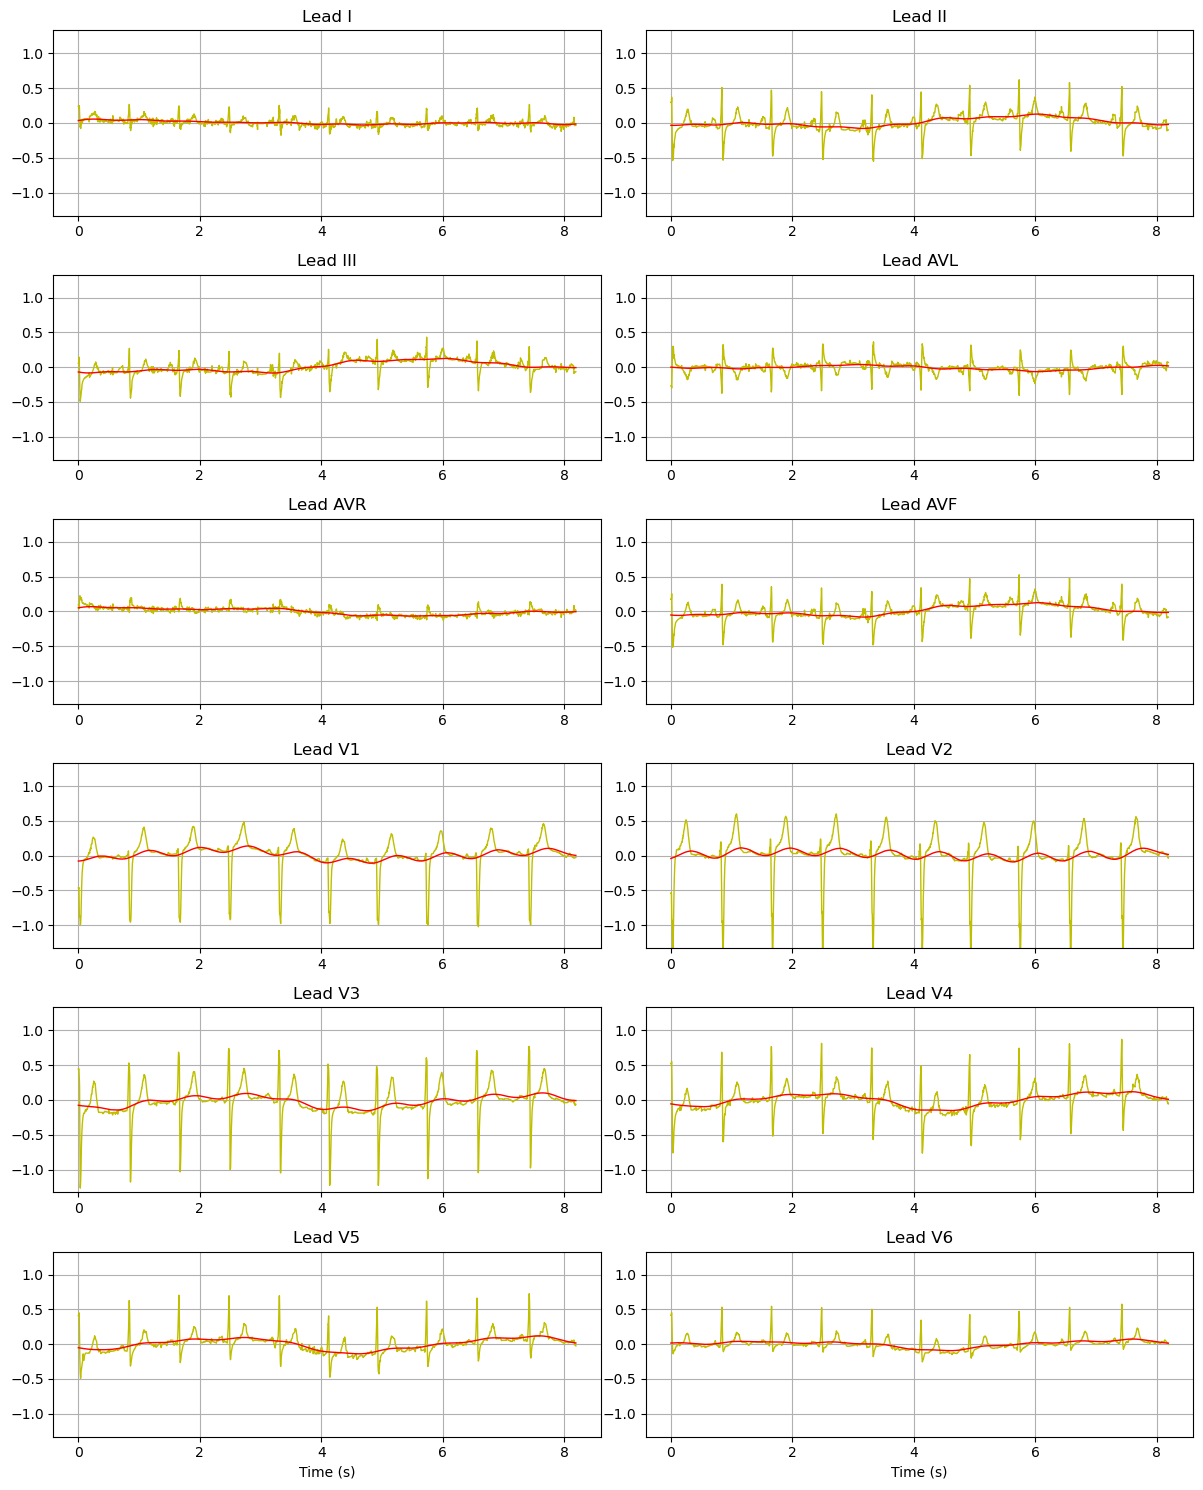

In [23]:
for ecgs, _, idxs in loader_test:
	print(idxs[1])
	baseline = preprocessor.lpf_lo(ecgs, fs=sampling_freq)
	ecg_processing.plot_ecg_record(ecgs[1], fs=sampling_freq, compare=baseline[1])
	break

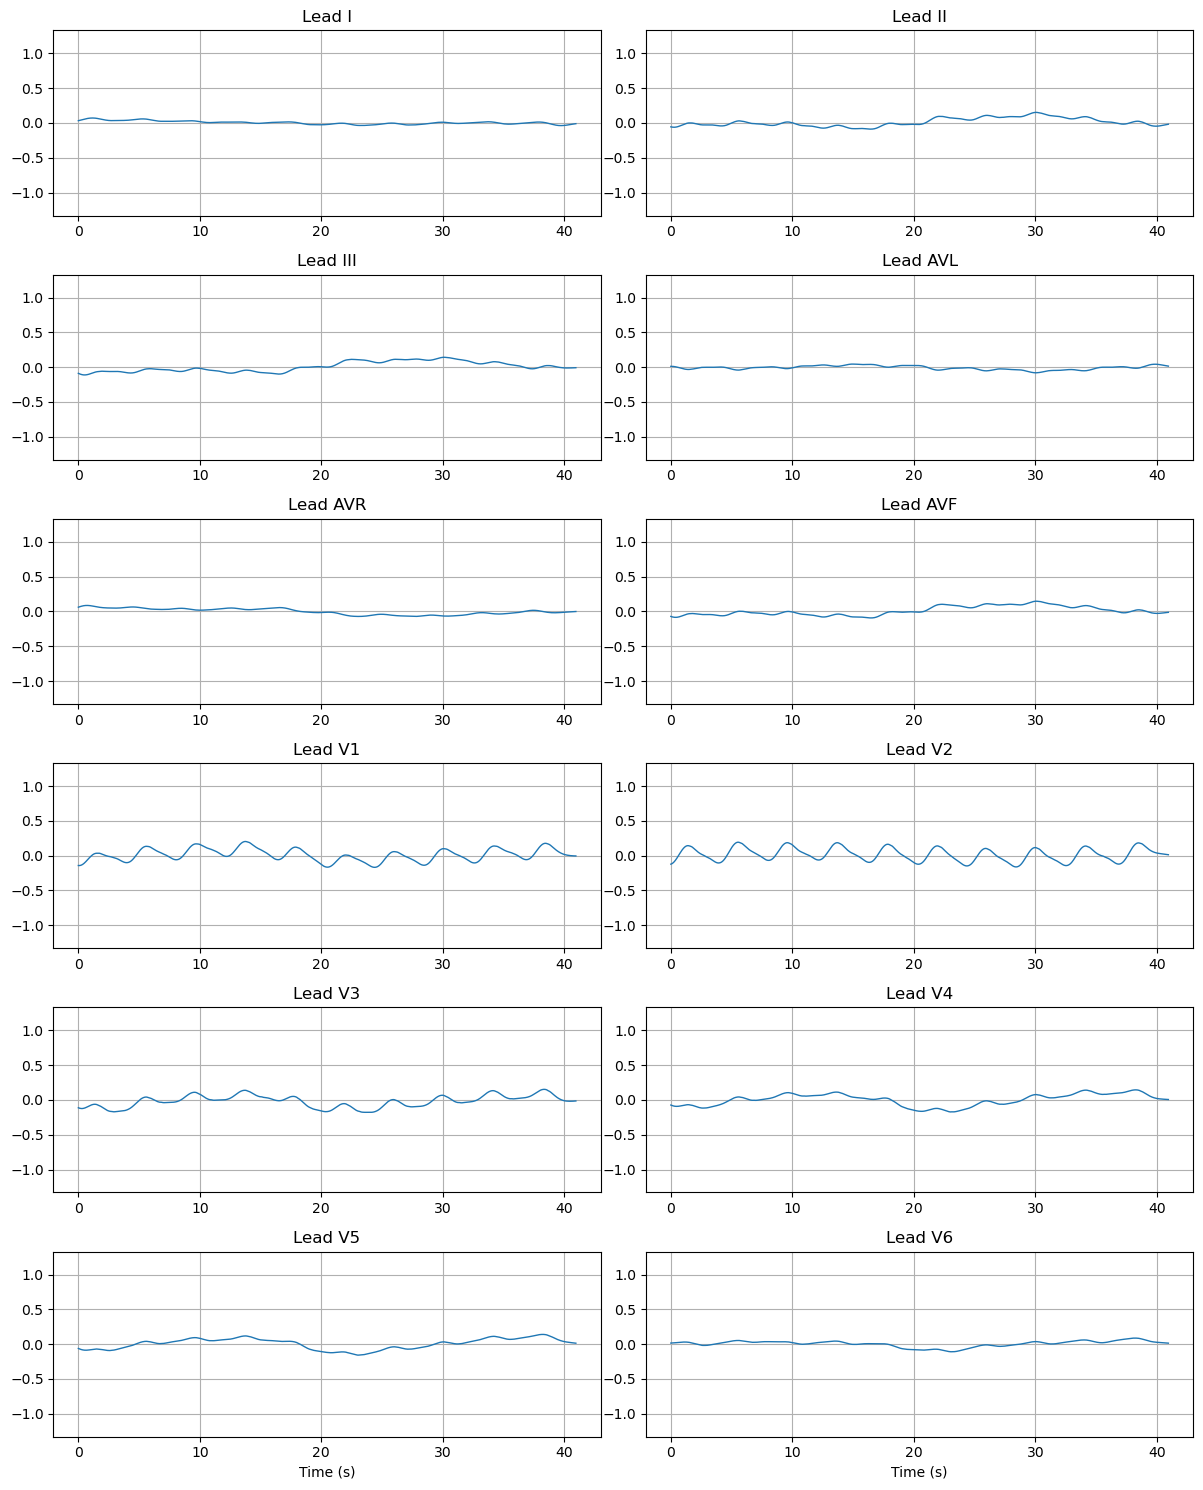

In [16]:
for ecgs, _, idxs in loader_test:
	# ecg_processing.plot_ecg_record(ecgs[1])
	baseline = preprocessor.lpf_lo(ecgs, fs=sampling_freq)
	ecg_processing.plot_ecg_record(baseline[1])
	break

In [72]:
model = resnet1d_chen.ResNet1d_chen(num_classes=1)
summary(model, input_size=(12,4096), device='cpu')

creating stem
creating backbone
creating head
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv1d-1             [-1, 64, 4096]          11,520
       BatchNorm1d-2             [-1, 64, 4096]             128
              ReLU-3             [-1, 64, 4096]               0
           Dropout-4             [-1, 64, 4096]               0
            Conv1d-5             [-1, 64, 1024]          61,440
       BatchNorm1d-6             [-1, 64, 1024]             128
              ReLU-7             [-1, 64, 1024]               0
           Dropout-8             [-1, 64, 1024]               0
            Conv1d-9             [-1, 64, 1024]          61,440
      BatchNorm1d-10             [-1, 64, 1024]             128
        MaxPool1d-11             [-1, 64, 1024]               0
           Conv1d-12             [-1, 64, 1024]           4,096
             ReLU-13             [-1, 64, 1024]          

In [73]:
# configure training hyperparameters
criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4) # learning rate was reduced by a factor of ten

In [74]:
# training prepare
print(device)
model = model.to(device)

cuda


In [75]:
# training loop

train_losses = []
val_losses = []

for epoch in range(num_epochs):
	# training
	model.train()
	train_loss = 0.0

	loader_train_tqdm = tqdm(loader_train, desc=f'{epoch+1}/{num_epochs} [Train]', leave=True)

	for batch in loader_train_tqdm:
		inputs, labels = [x.to(device) for x in batch]
		inputs = loader_train.dataset.preprocessor.normalize(inputs)

		optimizer.zero_grad()
		outputs = model(inputs)
		loss = criterion(outputs, labels)
		with torch.autograd.set_detect_anomaly(True):
			loss.backward()
		optimizer.step()

		train_loss += loss.item()

	avg_train_loss = train_loss / len(loader_train)
	train_losses.append(avg_train_loss)

	# validation
	model.eval()
	val_loss = 0.0
	loader_val_tqdm = tqdm(loader_val, desc=f'{epoch+1}/{num_epochs} [Val]  ', leave=True)
	with torch.no_grad():
		for batch in loader_val_tqdm:
			inputs, labels = [x.to(device) for x in batch]
			inputs = loader_train.dataset.preprocessor.normalize(inputs)

			outputs = model(inputs)
			loss = criterion(outputs, labels)
			val_loss += loss.item()

	avg_val_loss = val_loss / len(loader_val)
	val_losses.append(avg_val_loss)

	tqdm.write(f"train loss: {avg_train_loss:.4f} | val loss: {avg_val_loss:.4f}")

2/30 [Train]:   0%|          | 0/273 [00:00<?, ?it/s]

train loss: 0.4662 | val loss: 0.5813


3/30 [Train]:   0%|          | 0/273 [00:00<?, ?it/s]

train loss: 0.3929 | val loss: 0.5714


4/30 [Train]:   0%|          | 0/273 [00:00<?, ?it/s]

train loss: 0.3659 | val loss: 0.4197


5/30 [Train]:   0%|          | 0/273 [00:00<?, ?it/s]

train loss: 0.3414 | val loss: 0.4616


6/30 [Train]:   0%|          | 0/273 [00:00<?, ?it/s]

train loss: 0.3260 | val loss: 0.3961


7/30 [Train]:   0%|          | 0/273 [00:00<?, ?it/s]

train loss: 0.3053 | val loss: 0.3877


8/30 [Train]:   0%|          | 0/273 [00:00<?, ?it/s]

train loss: 0.2951 | val loss: 0.4052


9/30 [Train]:   0%|          | 0/273 [00:00<?, ?it/s]

train loss: 0.2881 | val loss: 0.3608


10/30 [Train]:   0%|          | 0/273 [00:00<?, ?it/s]

train loss: 0.2798 | val loss: 0.3772


11/30 [Train]:   0%|          | 0/273 [00:00<?, ?it/s]

train loss: 0.2760 | val loss: 0.3575


12/30 [Train]:   0%|          | 0/273 [00:00<?, ?it/s]

train loss: 0.2701 | val loss: 0.3646


13/30 [Train]:   0%|          | 0/273 [00:00<?, ?it/s]

train loss: 0.2647 | val loss: 0.3408


14/30 [Train]:   0%|          | 0/273 [00:00<?, ?it/s]

train loss: 0.2629 | val loss: 0.3510


15/30 [Train]:   0%|          | 0/273 [00:00<?, ?it/s]

train loss: 0.2566 | val loss: 0.3470


16/30 [Train]:   0%|          | 0/273 [00:00<?, ?it/s]

train loss: 0.2541 | val loss: 0.3452


17/30 [Train]:   0%|          | 0/273 [00:00<?, ?it/s]

train loss: 0.2509 | val loss: 0.3539


18/30 [Train]:   0%|          | 0/273 [00:00<?, ?it/s]

train loss: 0.2488 | val loss: 0.3682


19/30 [Train]:   0%|          | 0/273 [00:00<?, ?it/s]

train loss: 0.2445 | val loss: 0.3785


20/30 [Train]:   0%|          | 0/273 [00:00<?, ?it/s]

train loss: 0.2439 | val loss: 0.3435


21/30 [Train]:   0%|          | 0/273 [00:00<?, ?it/s]

train loss: 0.2375 | val loss: 0.3727


22/30 [Train]:   0%|          | 0/273 [00:00<?, ?it/s]

train loss: 0.2367 | val loss: 0.3620


23/30 [Train]:   0%|          | 0/273 [00:00<?, ?it/s]

train loss: 0.2343 | val loss: 0.4470


24/30 [Train]:   0%|          | 0/273 [00:00<?, ?it/s]

train loss: 0.2308 | val loss: 0.3887


25/30 [Train]:   0%|          | 0/273 [00:00<?, ?it/s]

train loss: 0.2292 | val loss: 0.3328


26/30 [Train]:   0%|          | 0/273 [00:00<?, ?it/s]

train loss: 0.2271 | val loss: 0.3588


27/30 [Train]:   0%|          | 0/273 [00:00<?, ?it/s]

train loss: 0.2239 | val loss: 0.3940


28/30 [Train]:   0%|          | 0/273 [00:00<?, ?it/s]

train loss: 0.2218 | val loss: 0.3915


29/30 [Train]:   0%|          | 0/273 [00:00<?, ?it/s]

train loss: 0.2178 | val loss: 0.4042


30/30 [Train]:   0%|          | 0/273 [00:00<?, ?it/s]

train loss: 0.2162 | val loss: 0.4081


30/30 [Val]  : 100%|██████████| 35/35 [00:07<00:00,  4.90it/s]


train loss: 0.2106 | val loss: 0.4356


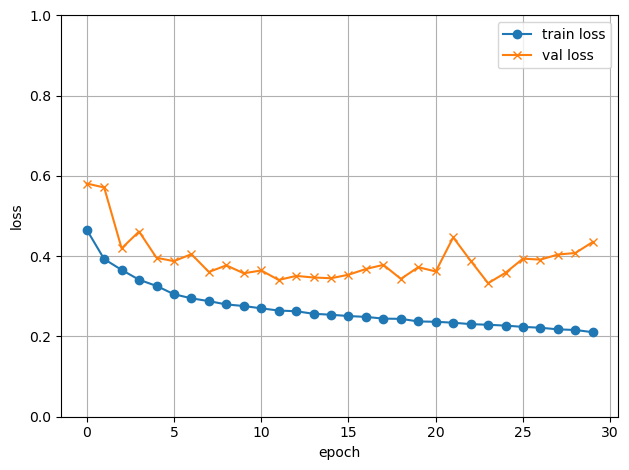

In [76]:
# train_losses = [0.4578, 0.3865, 0.3588, 0.3400, 0.3188, 0.3051, 0.2960, 0.2841, 0.2768, 0.2710]
# val_losses = [0.5643, 0.7357, 0.7207, 0.4875, 0.6307, 0.4596, 0.4450, 0.5175, 0.4177, 0.4944]
import matplotlib.pyplot as plt

epochs = range(num_epochs)

plt.figure()
plt.plot(epochs, train_losses, label='train loss', marker='o')
plt.plot(epochs, val_losses, label='val loss', marker='x')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.ylim(0, 1)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [77]:
# create output folder
experiment_folder = os.path.join(output_folder, experiment_id)
helper.check_create_folder(experiment_folder)

# save model weights
torch.save(model.state_dict(), os.path.join(experiment_folder, 'weights.pth'))

# save training result
training_result = pd.DataFrame({
	'train_loss':train_losses,
	'val_loss':val_losses
})
training_result.to_csv(os.path.join(experiment_folder, 'training_result.csv'), index=False)